# MTH5 Example 03

## ChannelTS Object

A `ChannelTS` object is a container for a single channel.  The data are stored in an `xarray.DataArray` and indexed by time according to the metadata provided.  Here we will make a simple `electric` channel and look at how to interogate it.

To get a `ChannelTS` object from an MTH5 file you can use

```
ch_dataset = mth5_object.get_channel("station", "run", "ex", survey="survey")
ch_ts = ch_dataset.to_channel_ts()
```

In [1]:
%matplotlib inline
import numpy as np
from mth5.timeseries import ChannelTS
from mt_metadata.timeseries import Electric, Run, Station

Here create some metadata, the keys are the `time_period.start` and the `sample_rate`. 

In [21]:
ex_metadata = Electric()
ex_metadata.time_period.start = "2020-01-01T00:00:00"
ex_metadata.sample_rate = 8.0
ex_metadata.component = "ex"
ex_metadata.dipole_length = 100.
ex_metadata.units = "millivolts"

Create `Station` and `Run` metadata

In [22]:
station_metadata = Station(id="mt001")
run_metadata = Run(id="001")

Create "realistic" data 

In [23]:
n_samples = 4096
t = np.arange(n_samples)
data = np.sum([np.cos(2*np.pi*w*t + phi) for w, phi in zip(np.logspace(-3, 3, 20), np.random.rand(20))], axis=0)

In [24]:
ex = ChannelTS(channel_type="electric",
              data=data,
              channel_metadata=ex_metadata,
              run_metadata=run_metadata,
              station_metadata=station_metadata)

In [25]:
ex

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  8.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T00:08:31.875000+00:00
	N Samples:    4096

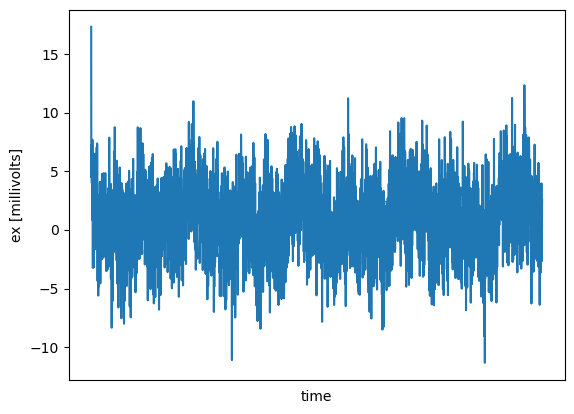

In [26]:
ex.plot()

/opt/conda/envs/geophys/lib/python3.9/site-packages/mth5/timeseries/channel_ts.py:1516: RuntimeWarning: divide by zero encountered in divide
  ax.loglog(1.0 / plot_frequency, power, lw=1.5)


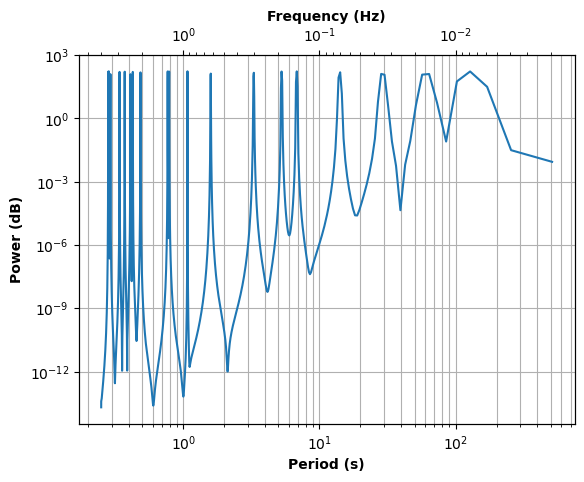

In [27]:
ex.plot_spectra()

## Get a slice of the data
Here we will provide a start time of the slice and the number of samples that we want the slice to be


In [28]:
ex_slice = ex.get_slice("2020-01-01T00:00:00", n_samples=256)

In [29]:
ex_slice

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  8.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T00:00:31.875000+00:00
	N Samples:    256

## Plot the data
This is a work in progress, but this can be done through the `xarray` container.

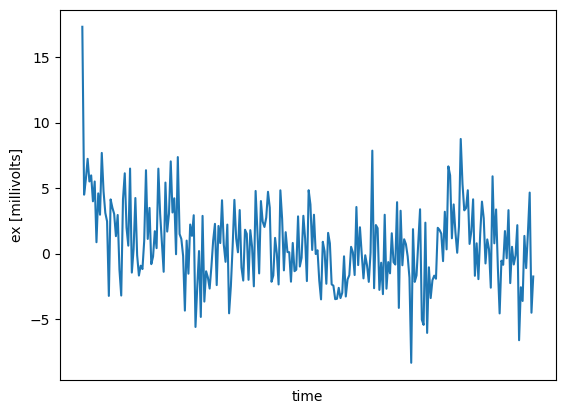

In [30]:
ex_slice.plot()

## Convert to an `xarray`
We can convert the `ChannelTS` object to an `xarray.DataArray` which could be easier to use.

In [31]:
ex_xarray = ex.to_xarray()

In [32]:
ex_xarray

<xarray.DataArray 'ex' (time: 4096)>
array([17.3344242 ,  4.50460604,  5.68457802, ..., -1.67675988,
        0.14538286,  2.56762065])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-01T00:08:31.875000
Attributes: (12/27)
    channel_number:             0
    component:                  ex
    data_quality.rating.value:  0
    dipole_length:              100.0
    filter.applied:             [False]
    filter.name:                []
    ...                         ...
    time_period.end:            2020-01-01T00:08:31.875000+00:00
    time_period.start:          2020-01-01T00:00:00+00:00
    type:                       electric
    units:                      millivolts
    station.id:                 mt001
    run.id:                     001

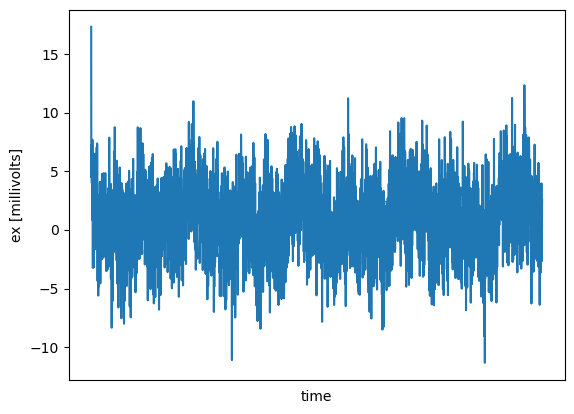

In [33]:
ex_xarray.plot()

## Interpolate and Resample

A common time series transformation is interpolation and resampling. Here we will use `scipy.interpolate.resample_poly` for an efficient and more accurate interpolation especially at the ends of the time series.   

In [34]:
decimated_ex = ex.resample_poly(1)

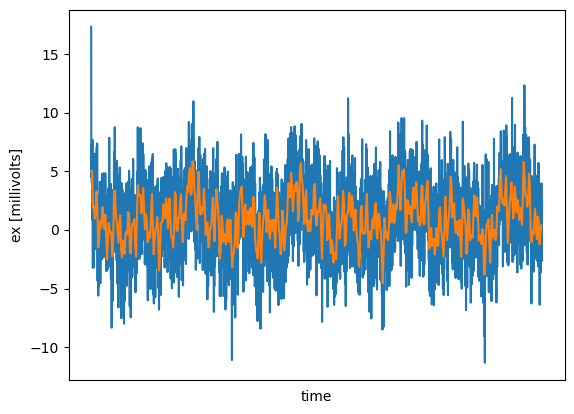

In [37]:
ex.plot(); decimated_ex.plot()

## Combine time series

One common thing to do with multiple time series is to combine them into a long time series.  This can be done one of two ways using `+` or `merge()` methods. Here we will simply copy `ex` and set the start time to begin 1 second after the end time.  This means that there is a 1 second gap or 8 samples missing between the end of the first time series and the beginning of the second time series.  When using the `+` method a linear interpolation between the two will be applied to fill the gap with a constant value.

In [39]:
ex2 = ex.copy()
ex2.start = ex.end + 1

In [40]:
ex2

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  8.0
	Start:        2020-01-01T00:08:32.875000+00:00
	End:          2020-01-01T00:17:04.750000+00:00
	N Samples:    4096

In [41]:
ex3 = ex + ex2

In [42]:
ex3

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  8.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T00:17:04.750000+00:00
	N Samples:    8199

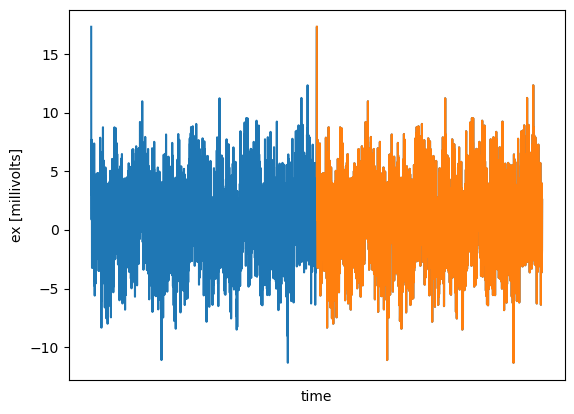

In [44]:
ex3.plot(); ex.plot; ex2.plot()

## Convert to an `Obspy.Trace` object
The `ChannelTS` object can be converted to an `obspy.Trace` object.  This can be useful when dealing with data received from a mainly seismic archive like IRIS.  This can also be useful for using some tools provided by [Obspy](https://docs.obspy.org/).  

**Note** there is a loss of information when doing this because an `obspy.Trace` is based on miniSEED data formats which has minimal metadata.  

In [14]:
ex.station_metadata.fdsn.id = "mt001"
ex_trace = ex.to_obspy_trace()

In [15]:
ex_trace

.mt001..LQN | 2020-01-01T00:00:00.000000Z - 2020-01-01T01:08:15.000000Z | 1.0 Hz, 4096 samples

## Convert from an `Obspy.Trace` object
We can reverse that and convert an `obspy.Trace` into a `ChannelTS`.  Again useful when dealing with seismic dominated archives.

In [16]:
ex_from_trace = ChannelTS()
ex_from_trace.from_obspy_trace(ex_trace)

In [17]:
ex_from_trace

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          sr1_001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T01:08:15+00:00
	N Samples:    4096

In [18]:
ex

Channel Summary:
	Survey:       0
	Station:      mt001
	Run:          001
	Channel Type: Electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T01:08:15+00:00
	N Samples:    4096

On comparison you can see the loss of metadata information.  

## Calibrate 

Removing the instrument response to calibrate the data is an important step in processing the data.  A convenience function `ChannelTS.remove_instrument_response` is supplied just for this.  
Currently, it will calibrate the whole time series at once and therefore may be slow for large data sets.  

**SEE ALSO**: `Make Data From IRIS` examples for working examples.

In [19]:
help(ex.remove_instrument_response)

Help on method remove_instrument_response in module mth5.timeseries.channel_ts:

remove_instrument_response(**kwargs) method of mth5.timeseries.channel_ts.ChannelTS instance
    Remove instrument response from the given channel response filter
    
    The order of operations is important (if applied):
    
        1) detrend
        2) zero mean
        3) zero pad
        4) time window
        5) frequency window
        6) remove response
        7) undo time window
        8) bandpass
    
    **kwargs**
    
    :param plot: to plot the calibration process [ False | True ]
    :type plot: boolean, default True
    :param detrend: Remove linar trend of the time series
    :type detrend: boolean, default True
    :param zero_mean: Remove the mean of the time series
    :type zero_mean: boolean, default True
    :param zero_pad: pad the time series to the next power of 2 for efficiency
    :type zero_pad: boolean, default True
    :param t_window: Time domain windown name see `scipy